In [1]:
########################
# House Prediction Model
######################### Using a dataset containing the characteristics and prices of each house,
# a machine learning project related to the prices of different types of houses
# is to be carried out.edirThis dataset, consisting of residential homes in Ames, Iowa, contains 79 explanatory variables. You can access the dataset and competition page for the competition on Kaggle
#. The dataset and competition page for the project can be accessed via the link below. Since the dataset belongs to a Kaggle competition
#, there are two separate CSV files: one for training and one for testing. In the test dataset, the house prices are left blank, and you are expected to
# predict these vuesr.
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

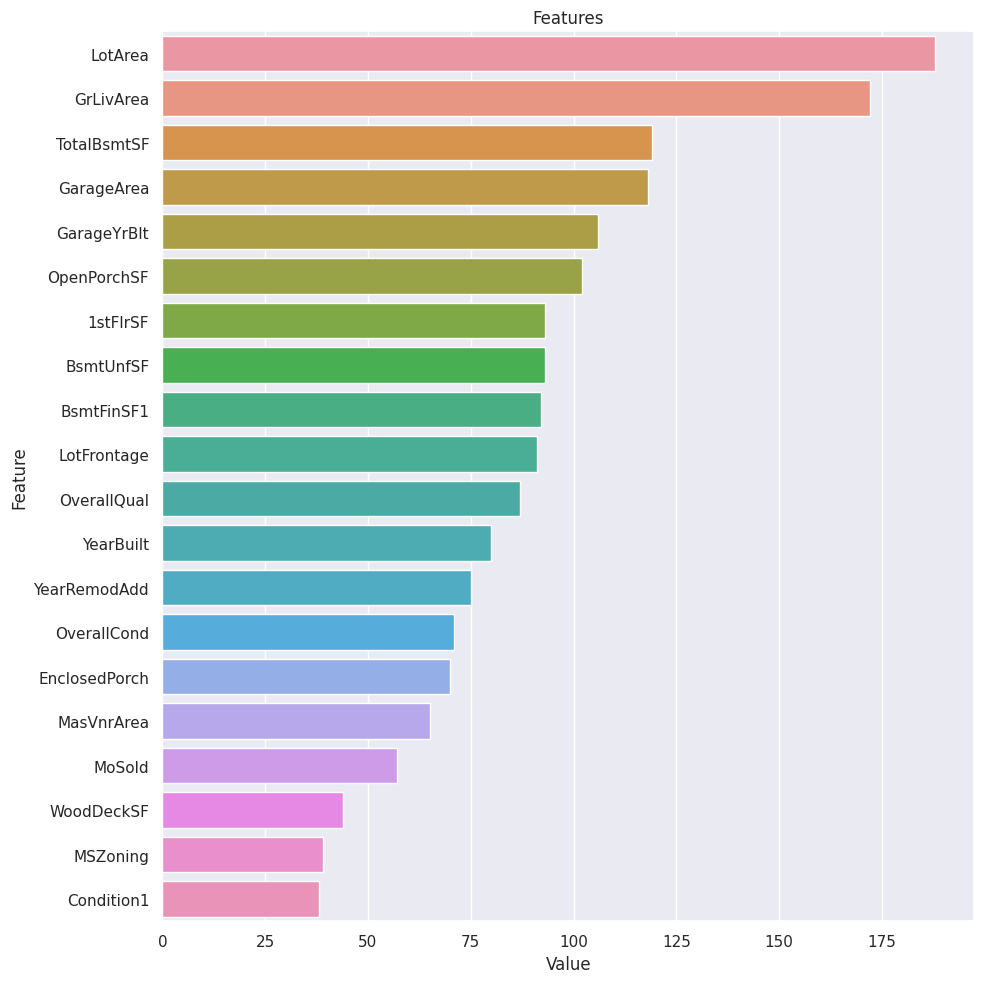

In [2]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns  


from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import GridSearchCV, cross_validate  
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width',500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read and merge the Train and Test data sets. Proceed with the merged data.

test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# 📌 track which observation came from which file:
train["set"] = "train"
test["set"]  = "test"
df = pd.concat([train, test], ignore_index=True)
df.head()
df.dtypes
df.info()

# Grabbing cat & num cols

def grab_col_names(dataframe, cat_th=10, car_th=20):
   
    # Grabbing cat_cols
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    # Grabbing num_cols
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]

    # Grabbing categoric but cardinal
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    # Cat 
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Num
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Results
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)



# Observe the distribution of numerical and categorical variables within the data.

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col)
    
# ⚠️ if you want to observe add plot=True

# Examine the target variable with categorical variables.

def target_summary_with_cat(dataframe, target, categorical_col):
   
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "SalePrice", col)

df.columns

# Checking Outlier

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
        
for col in df.columns:
    print(col, check_outlier(df, num_cols))

# Missing Values

df.isnull().sum()




# Görev 2: Feature Engineering
##############################

# Outlier & Missing Values Fixing

df[num_cols] = df[num_cols].fillna(df[num_cols].median())


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))  

# Applying Rare Encoder 

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp <= rare_perc].index # 📌 eşik değerden küçük indexleri tut
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.01)

rare_analyser(df, "SalePrice", cat_cols)
df.nunique()




# Label Encoding

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df.head()

# Building Model
######################

# Split Train & Test 

train_df = df[df["set"] == 1].drop("set", axis=1)
test_df  = df[df["set"] == 0].drop("set", axis=1)

# Build Model on Train 

# Bonus: Build a model by performing a log transformation on the target variable and observe the rmse results. Not: Dont forget inverse log 


X_train = train_df.drop(['SalePrice', 'Id', "Neighborhood"], axis=1)
y_train = train_df['SalePrice']


y_train_log = np.log1p(y_train) # 📌 Log transfomation

lgbm_model = LGBMRegressor(random_state=17, verbose=-1).fit(X_train, y_train_log)

y_train_pred_log = lgbm_model.predict(X_train)

y_train_pred_real = np.expm1(y_train_pred_log) # 📌 inverse log

# Orijinal hedef ve inverse log tahminler

train_rmse = np.sqrt(mean_squared_error(y_train , y_train_pred_real))


# Hyperparameter Optimization

lgbm_model.get_params()
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1],
               'max_depth': [-1, 2 , 3 , 4]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train_log)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train_log)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final,
                                 X_train,
                                 y_train_log,
                                 cv=5,
                                 scoring="neg_mean_squared_error")))



# Feature Importance

def plot_importance(model, features, num=len(X_train), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(lgbm_model, X_train, num=20)



# Predict the SalePrice variables that are empty in the test data and create a dataframe suitable for submission to the Kaggle page.
# Upload your results.

lgbm_final.fit(X_train, y_train_log)

X_test = test_df.drop(['Id', 'SalePrice', 'Neighborhood'], axis=1)

y_test_pred_log = lgbm_final.predict(X_test)

y_test_pred = np.expm1(y_test_pred_log)


# ✅ Suitable For Submission to Kaggle Page

test_df['SalePrice'] = y_test_pred

test_df[['Id', 'SalePrice']].astype({'Id': 'int32'}).to_csv('submission.csv', index=False)